[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/

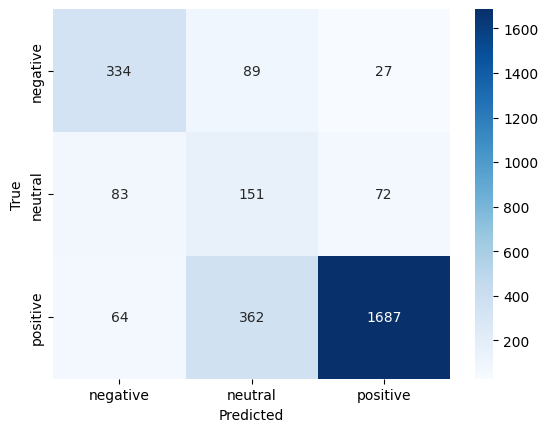

Epoch 1/20, Loss: 0.6603, Accuracy: 0.7020
Epoch 2/20, Loss: 0.5589, Accuracy: 0.7632
Epoch 3/20, Loss: 0.5409, Accuracy: 0.7730
Epoch 4/20, Loss: 0.5277, Accuracy: 0.7787
Epoch 5/20, Loss: 0.5176, Accuracy: 0.7836
Epoch 6/20, Loss: 0.5091, Accuracy: 0.7856
Epoch 7/20, Loss: 0.5026, Accuracy: 0.7884
Epoch 8/20, Loss: 0.4942, Accuracy: 0.7947
Epoch 9/20, Loss: 0.4899, Accuracy: 0.7955
Epoch 10/20, Loss: 0.4823, Accuracy: 0.7986
Epoch 11/20, Loss: 0.4763, Accuracy: 0.8040
Epoch 12/20, Loss: 0.4691, Accuracy: 0.8055
Epoch 13/20, Loss: 0.4617, Accuracy: 0.8068
Epoch 14/20, Loss: 0.4592, Accuracy: 0.8102
Epoch 15/20, Loss: 0.4485, Accuracy: 0.8130
Epoch 16/20, Loss: 0.4423, Accuracy: 0.8161
Epoch 17/20, Loss: 0.4378, Accuracy: 0.8186
Epoch 18/20, Loss: 0.4306, Accuracy: 0.8236
Epoch 19/20, Loss: 0.4251, Accuracy: 0.8250
Epoch 20/20, Loss: 0.4161, Accuracy: 0.8272

Validation 2 Accuracy: 0.7177

              precision    recall  f1-score   support

    negative       0.65      0.76      0.7

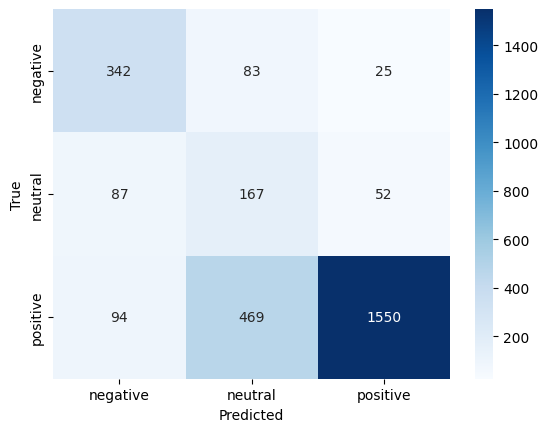

Epoch 1/20, Loss: 0.6564, Accuracy: 0.7051
Epoch 2/20, Loss: 0.5625, Accuracy: 0.7633
Epoch 3/20, Loss: 0.5408, Accuracy: 0.7741
Epoch 4/20, Loss: 0.5255, Accuracy: 0.7804
Epoch 5/20, Loss: 0.5159, Accuracy: 0.7842
Epoch 6/20, Loss: 0.5056, Accuracy: 0.7879
Epoch 7/20, Loss: 0.4960, Accuracy: 0.7910
Epoch 8/20, Loss: 0.4899, Accuracy: 0.7934
Epoch 9/20, Loss: 0.4797, Accuracy: 0.7992
Epoch 10/20, Loss: 0.4737, Accuracy: 0.7996
Epoch 11/20, Loss: 0.4688, Accuracy: 0.8037
Epoch 12/20, Loss: 0.4608, Accuracy: 0.8060
Epoch 13/20, Loss: 0.4533, Accuracy: 0.8126
Epoch 14/20, Loss: 0.4433, Accuracy: 0.8152
Epoch 15/20, Loss: 0.4369, Accuracy: 0.8190
Epoch 16/20, Loss: 0.4297, Accuracy: 0.8214
Epoch 17/20, Loss: 0.4188, Accuracy: 0.8285
Epoch 18/20, Loss: 0.4130, Accuracy: 0.8321
Epoch 19/20, Loss: 0.4047, Accuracy: 0.8354
Epoch 20/20, Loss: 0.3985, Accuracy: 0.8374

Validation 3 Accuracy: 0.7588

              precision    recall  f1-score   support

    negative       0.70      0.72      0.7

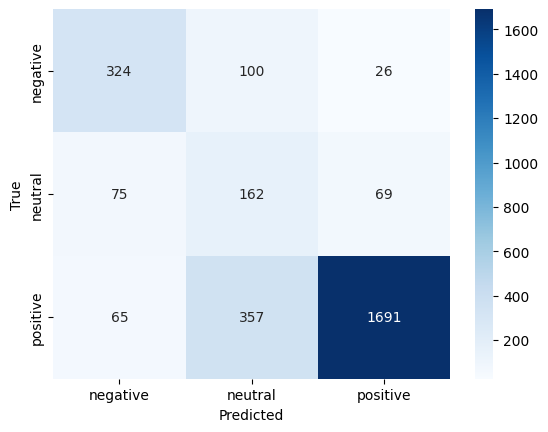

Epoch 1/20, Loss: 0.6467, Accuracy: 0.7073
Epoch 2/20, Loss: 0.5531, Accuracy: 0.7643
Epoch 3/20, Loss: 0.5370, Accuracy: 0.7748
Epoch 4/20, Loss: 0.5204, Accuracy: 0.7843
Epoch 5/20, Loss: 0.5151, Accuracy: 0.7861
Epoch 6/20, Loss: 0.5054, Accuracy: 0.7906
Epoch 7/20, Loss: 0.4959, Accuracy: 0.7947
Epoch 8/20, Loss: 0.4904, Accuracy: 0.7952
Epoch 9/20, Loss: 0.4844, Accuracy: 0.7994
Epoch 10/20, Loss: 0.4772, Accuracy: 0.8022
Epoch 11/20, Loss: 0.4668, Accuracy: 0.8060
Epoch 12/20, Loss: 0.4630, Accuracy: 0.8072
Epoch 13/20, Loss: 0.4552, Accuracy: 0.8103
Epoch 14/20, Loss: 0.4492, Accuracy: 0.8113
Epoch 15/20, Loss: 0.4406, Accuracy: 0.8162
Epoch 16/20, Loss: 0.4341, Accuracy: 0.8210
Epoch 17/20, Loss: 0.4254, Accuracy: 0.8224
Epoch 18/20, Loss: 0.4167, Accuracy: 0.8272
Epoch 19/20, Loss: 0.4120, Accuracy: 0.8307
Epoch 20/20, Loss: 0.4031, Accuracy: 0.8336

Validation 4 Accuracy: 0.7619

              precision    recall  f1-score   support

    negative       0.75      0.70      0.7

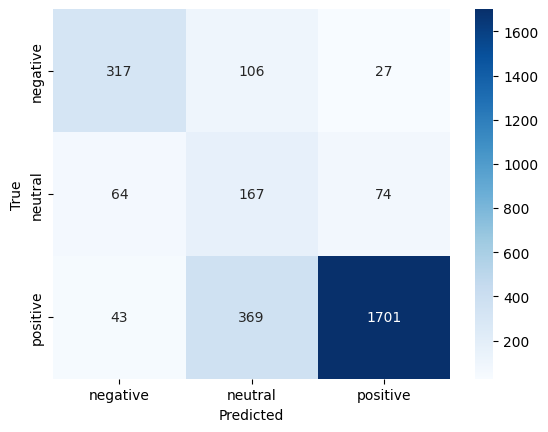

Epoch 1/20, Loss: 0.6682, Accuracy: 0.6989
Epoch 2/20, Loss: 0.5722, Accuracy: 0.7581
Epoch 3/20, Loss: 0.5518, Accuracy: 0.7701
Epoch 4/20, Loss: 0.5364, Accuracy: 0.7777
Epoch 5/20, Loss: 0.5279, Accuracy: 0.7808
Epoch 6/20, Loss: 0.5168, Accuracy: 0.7857
Epoch 7/20, Loss: 0.5112, Accuracy: 0.7873
Epoch 8/20, Loss: 0.5033, Accuracy: 0.7922
Epoch 9/20, Loss: 0.4944, Accuracy: 0.7913
Epoch 10/20, Loss: 0.4880, Accuracy: 0.7964
Epoch 11/20, Loss: 0.4774, Accuracy: 0.8017
Epoch 12/20, Loss: 0.4712, Accuracy: 0.8043
Epoch 13/20, Loss: 0.4612, Accuracy: 0.8081
Epoch 14/20, Loss: 0.4525, Accuracy: 0.8128
Epoch 15/20, Loss: 0.4432, Accuracy: 0.8185
Epoch 16/20, Loss: 0.4344, Accuracy: 0.8234
Epoch 17/20, Loss: 0.4231, Accuracy: 0.8253
Epoch 18/20, Loss: 0.4171, Accuracy: 0.8306
Epoch 19/20, Loss: 0.4069, Accuracy: 0.8350
Epoch 20/20, Loss: 0.4022, Accuracy: 0.8391

Validation 5 Accuracy: 0.7559

              precision    recall  f1-score   support

    negative       0.69      0.70      0.7

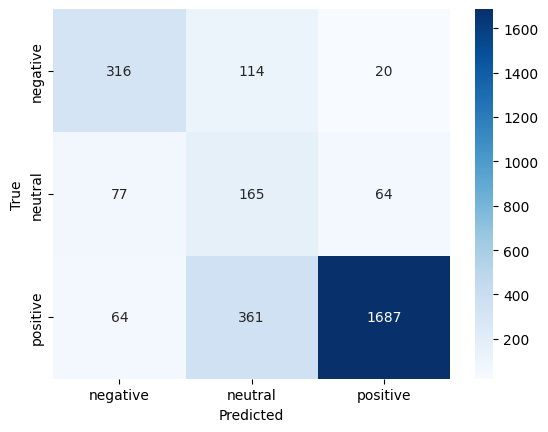

Best Validation Accuracy: 0.7619

Final Test Accuracy: 0.7645

              precision    recall  f1-score   support

    negative       0.74      0.74      0.74       964
     neutral       0.25      0.50      0.34       655
    positive       0.94      0.81      0.87      4529

    accuracy                           0.76      6148
   macro avg       0.65      0.68      0.65      6148
weighted avg       0.84      0.76      0.79      6148


Final Confusion Matrix:
[[ 717  193   54]
 [ 149  330  176]
 [ 103  773 3653]]



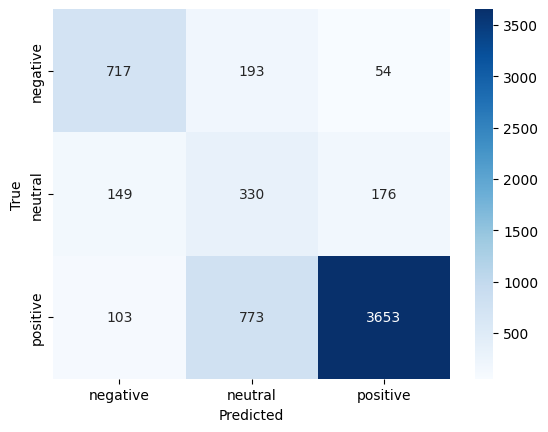

In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import KeyedVectors
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import normalize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
data_path = '/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv'
data = pd.read_csv(data_path)

# Preprocessing: Text Cleaning, Tokenization, and Normalization
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['Cleaned_Review'] = data['Review'].apply(preprocess_text)

# Create sentiment labels from ratings
def rating_to_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

data['Sentiment'] = data['Rating'].apply(rating_to_sentiment)

# Convert 'Sentiment' column to category
data['Sentiment'] = data['Sentiment'].astype('category')

# Split data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.3, stratify=data['Sentiment'], random_state=42)

# Print sentiment counts in training and test sets
print("Sentiment counts in training set:")
print(train_data['Sentiment'].value_counts())

print("\nSentiment counts in testing set:")
print(test_data['Sentiment'].value_counts())

# Load FastText model
fasttext_model_path = '/kaggle/input/fasttext-wikinews/wiki-news-300d-1M.vec'
fasttext_vectors = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False)

# Convert text data to FastText vectors (average of word vectors)
def text_to_vector(text):
    tokens = nltk.word_tokenize(text.lower())
    vectors = [fasttext_vectors[word] for word in tokens if word in fasttext_vectors]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

X_train_vectors = np.array([text_to_vector(text) for text in train_data['Cleaned_Review']])
X_test_vectors = np.array([text_to_vector(text) for text in test_data['Cleaned_Review']])

# Normalize vectors
X_train_vectors = normalize(X_train_vectors, axis=1)
X_test_vectors = normalize(X_test_vectors, axis=1)

# Convert y_train and y_test to categorical dtype
y_train = train_data['Sentiment'].cat.codes
y_test = test_data['Sentiment'].cat.codes

# Convert to tensors
X_train_tensor = torch.tensor(X_train_vectors, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_vectors, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Define LSTM model
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(SentimentLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add dimension for seq_length
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return output

    # Cross-validation and hyperparameter tuning
def cross_validate_and_tune(X_train, y_train, num_folds=5, num_epochs=20):
    skf = StratifiedKFold(n_splits=num_folds)
    best_model = None
    best_acc = 0.0
    
    for num_evaluation, (train_index, val_index) in enumerate(skf.split(X_train.cpu().numpy(), y_train.cpu().numpy())):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Move tensors to CPU and convert to NumPy arrays for SMOTE
        X_train_fold = X_train_fold.cpu().numpy()
        X_val_fold = X_val_fold.cpu().numpy()
        y_train_fold = y_train_fold.cpu().numpy()
        y_val_fold = y_val_fold.cpu().numpy()

        # Apply SMOTE to the training data
        smote = SMOTE(sampling_strategy='auto', random_state=42)  
        X_train_smote, y_train_smote = smote.fit_resample(X_train_fold, y_train_fold)

        # Convert to tensors and move to GPU
        X_train_tensor = torch.tensor(X_train_smote, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train_smote, dtype=torch.long).to(device)
        X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long).to(device)
        
        # Define parameters
        input_size = 300  # Size of FastText word vectors
        hidden_size = 128
        output_size = len(data['Sentiment'].unique())
        
        # Calculate class weights
        class_counts = Counter(y_train_smote)
        total_samples = len(y_train_smote)
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        class_weights_tensor = torch.tensor([class_weights[cls] for cls in sorted(class_counts.keys())], dtype=torch.float32).to(device)
        
        # Create LSTM model instance
        lstm_model = SentimentLSTM(input_size, hidden_size, output_size, num_layers=2, dropout=0.3).to(device)

        # Define optimizer and loss function
        optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
        
        # Define DataLoader
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

        # Training loop
        def train_model(model, train_loader, optimizer, loss_fn, num_epochs):
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct_predictions = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    correct_predictions += (predicted == labels).sum().item()

                epoch_loss = running_loss / len(train_loader.dataset)
                epoch_acc = correct_predictions / len(train_loader.dataset)
                print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            return model

        # Train the model
        trained_model = train_model(lstm_model, train_loader, optimizer, loss_fn, num_epochs)

        # Evaluate the model
        def evaluate_model(model, X_val_tensor, y_val_tensor):
            model.eval()
            with torch.no_grad():
                outputs = model(X_val_tensor)
                _, predicted = torch.max(outputs, 1)
                acc = (predicted == y_val_tensor).sum().item() / len(y_val_tensor)
                cm = confusion_matrix(y_val_tensor.cpu(), predicted.cpu())
                cr = classification_report(y_val_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
            return acc, cm, cr

        val_acc, val_cm, val_cr = evaluate_model(trained_model, X_val_tensor, y_val_tensor)
        print(f'\nValidation {num_evaluation + 1} Accuracy: {val_acc:.4f}\n')
        print(val_cr)
        print(f'\nConfusion Matrix:\n{val_cm}\n')
        sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = trained_model

    return best_model, best_acc

# Perform cross-validation and hyperparameter tuning
best_model, best_accuracy = cross_validate_and_tune(X_train_tensor, y_train_tensor, num_folds=5, num_epochs=20)
print(f'Best Validation Accuracy: {best_accuracy:.4f}')

# Evaluate the final model on the test set
def evaluate_final_model(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        cm = confusion_matrix(y_test_tensor.cpu(), predicted.cpu())
        cr = classification_report(y_test_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
    return acc, cm, cr

final_acc, final_cm, final_cr = evaluate_final_model(best_model, X_test_tensor, y_test_tensor)
print(f'\nFinal Test Accuracy: {final_acc:.4f}\n')
print(final_cr)
print(f'\nFinal Confusion Matrix:\n{final_cm}\n')
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
